In [1]:
from binance.client import Client
import pandas as pd
from datetime import datetime
import numpy as np

class BinanceDataFetcher:
    def __init__(self):
        api_key = "rxirPy024UMkqjXGc7qWlD2euuxFMgQ2FZlWeSESSFSS8L0Q8mp5TeCvTX5SPZGX"
        api_secret = "TfZfIqudcTova5TZXwDV7O3VUaHpyNmpoiXJDfHgtsYwK4m0ttxlmaWSiVA6cuJ0"
        self.client = Client(api_key, api_secret, tld="us")

    def check_binance_connection(self):
        try:
            self.client.ping()
            return True
        except Exception as e:
            print(f"Failed to connect to Binance API: {e}")
            return False

    def get_data(self, symbol, interval, start, end):
        from_d, from_m, from_y = start
        to_d, to_m, to_y = end
        range_from = f"{from_y}-{from_m:02d}-{from_d:02d}T00:00:00Z"
        range_to = f"{to_y}-{to_m:02d}-{to_d:02d}T00:00:00Z"

        try:
            klines = self.client.get_historical_klines(symbol, interval, range_from, range_to)
            return klines
        except Exception as e:
            print(f"Error fetching data: {e}")
            return []


def feature_engineering(df):
  df['adjust_close'] = df['Close'] / df['Close'].std()
  df['close_return'] = df['Close'].pct_change()
  df['normalized_close'] = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
  df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
  df['momentum_10'] = df['Close'] - df['Close'].shift(10)
  df['roc_10'] = (df['Close'] / df['Close'].shift(10)) - 1
  df['daily_range'] = df['High'] - df['Low']
  df['volatility_20'] = df['close_return'].rolling(window=20).std() * np.sqrt(252)
  df['cumulative_return'] = (1 + df['close_return']).cumprod() - 1
  df['tr'] = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift(1)), abs(df['Low'] - df['Close'].shift(1))))
  df['atr_14'] = df['tr'].rolling(window=14).mean()
  return df

def create_dataframe(klines):
  # Create the dataframe
  df = pd.DataFrame(klines)

  # Adding columns
  df.columns = ['Open time', 'Open', 'High', 'Low','Close' ,'Volume',\
                'Close time', 'Quote asset volume', 'Number of trades',\
                'Taker buy base asset volume', 'Taker buy quote asset volume',\
              'Ignore']

  # Creating the date column
  arr = []
  for date in df.iloc[:, 0]:
    d = datetime.fromtimestamp(int(date)/1000)
    arr.append(d)

  # date column added into dataframe
  df.insert(loc=0, column='Date', value=arr)
  # other 5 columns
  df = df.iloc[:, :7]

  # convert object to float
  df["Open"] = df.Open.astype(float)
  df["High"] = df.High.astype(float)
  df["Low"] = df.Low.astype(float)
  df["Close"] = df.Close.astype(float)
  df["Volume"] = df.Volume.astype(float)

  # Set DateTimeIndex
  df = df.set_index('Date')

  # feature engineering
  df = feature_engineering(df)

  return df


In [2]:
data = BinanceDataFetcher().get_data(symbol='BTCUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2024))
df = create_dataframe(data)
df.head()

/tmp/ipykernel_1984/693791528.py:27: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = self.client.get_historical_klines(symbol, interval, range_from, range_to)


,Open time,Open,High,Low,Close,Volume,adjust_close,close_return,normalized_close,log_return,momentum_10,roc_10,daily_range,volatility_20,cumulative_return,tr,atr_14
Date,,,,,,,,,,,,,,,,,
2023-01-01 03:30:00,1672531200000,16524.41,16628.20,16497.67,16617.57,309.056051,0.984913,NaN,0.000000,NaN,NaN,NaN,130.53,NaN,NaN,NaN,NaN
2023-01-02 03:30:00,1672617600000,16619.93,16785.92,16549.68,16677.87,713.131373,0.988486,0.003629,0.001069,0.003622,NaN,NaN,236.24,NaN,0.003629,236.24,NaN
2023-01-03 03:30:00,1672704000000,16674.84,16774.53,16604.95,16674.12,743.945758,0.988264,-0.000225,0.001003,-0.000225,NaN,NaN,169.58,NaN,0.003403,169.58,NaN
2023-01-04 03:30:00,1672790400000,16676.49,16984.83,16653.41,16849.97,1511.331821,0.998687,0.010546,0.004120,0.010491,NaN,NaN,331.42,NaN,0.013985,331.42,NaN
2023-01-05 03:30:00,1672876800000,16852.47,16878.61,16756.91,16832.48,722.090851,0.997650,-0.001038,0.003810,-0.001039,NaN,NaN,121.70,NaN,0.012933,121.70,NaN


In [3]:
df['price_change_pct'] = (df['High'] - df['Low']) / df['Low'] * 100
df.head()

,Open time,Open,High,Low,Close,Volume,adjust_close,close_return,normalized_close,log_return,momentum_10,roc_10,daily_range,volatility_20,cumulative_return,tr,atr_14,price_change_pct
Date,,,,,,,,,,,,,,,,,,
2023-01-01 03:30:00,1672531200000,16524.41,16628.20,16497.67,16617.57,309.056051,0.984913,NaN,0.000000,NaN,NaN,NaN,130.53,NaN,NaN,NaN,NaN,0.791203
2023-01-02 03:30:00,1672617600000,16619.93,16785.92,16549.68,16677.87,713.131373,0.988486,0.003629,0.001069,0.003622,NaN,NaN,236.24,NaN,0.003629,236.24,NaN,1.427460
2023-01-03 03:30:00,1672704000000,16674.84,16774.53,16604.95,16674.12,743.945758,0.988264,-0.000225,0.001003,-0.000225,NaN,NaN,169.58,NaN,0.003403,169.58,NaN,1.021262
2023-01-04 03:30:00,1672790400000,16676.49,16984.83,16653.41,16849.97,1511.331821,0.998687,0.010546,0.004120,0.010491,NaN,NaN,331.42,NaN,0.013985,331.42,NaN,1.990103
2023-01-05 03:30:00,1672876800000,16852.47,16878.61,16756.91,16832.48,722.090851,0.997650,-0.001038,0.003810,-0.001039,NaN,NaN,121.70,NaN,0.012933,121.70,NaN,0.726268


In [4]:
bins = [0, 2.5, 5, float('inf')]
labels = ['0-2.5%', '2.5-5%', '>5%']

df['price_change_category'] = pd.cut(df['price_change_pct'], bins=bins, labels=labels, right=True)

# Count occurrences in each category
category_counts = df['price_change_category'].value_counts().sort_index()

# Calculate percentage of values greater than 2.5%
above_2_5_pct = category_counts.loc[['2.5-5%', '>5%']].sum() / category_counts.sum() * 100

print(category_counts)
print(f"Percentage of all price changes above 2.5%: {above_2_5_pct:.2f}%")


price_change_category
0-2.5%    220
2.5-5%    241
>5%       125
Name: count, dtype: int64
Percentage of all price changes above 2.5%: 62.46%


In [5]:
df.to_csv("price_analysis.csv")

#Ploting

In [6]:
# # Risk free rate
df['close_return'].mean() * df.shape[0]
average_yield = df['close_return'].mean()
# # print(f"Average Yield for 10-Year Treasury Bond: {average_yield:.4f}%")
average_yield * 100

df['close_return'].std() * 100

2.556213566921252

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Create a figure and a grid of subplots
fig, axs = plt.subplots(5, 2, figsize=(16, 24))

# Plot Adjusted Close Price
axs[0, 0].plot(df.index, df['adjust_close'], label="Adjusted Close", color='blue')
axs[0, 0].set_title('Adjusted Close')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Adjusted Close')

# Plot Close Returns
axs[0, 1].plot(df.index, df['close_return'], label="Close Returns", color='green')
axs[0, 1].set_title('Close Returns')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Close Returns')

# Plot Normalized Close Price
axs[1, 0].plot(df.index, df['normalized_close'], label="Normalized Close", color='orange')
axs[1, 0].set_title('Normalized Close Price')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Normalized Close')

# Plot Log Returns
axs[1, 1].plot(df.index, df['log_return'], label="Log Returns", color='red')
axs[1, 1].set_title('Log Returns')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Log Returns')

# Plot Momentum (10-day)
axs[2, 0].plot(df.index, df['momentum_10'], label="Momentum (10-day)", color='purple')
axs[2, 0].set_title('Momentum (10-day)')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Momentum')

# Plot ROC (10-day)
axs[2, 1].plot(df.index, df['roc_10'], label="Rate of Change (10-day)", color='brown')
axs[2, 1].set_title('Rate of Change (10-day)')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('ROC')

# Plot Daily Range (High - Low)
axs[3, 0].plot(df.index, df['daily_range'], label="Daily Range", color='pink')
axs[3, 0].set_title('Daily Range (High - Low)')
axs[3, 0].set_xlabel('Date')
axs[3, 0].set_ylabel('Range')

# Plot Volatility (20-day)
axs[3, 1].plot(df.index, df['volatility_20'], label="Volatility (20-day)", color='cyan')
axs[3, 1].set_title('Volatility (20-day)')
axs[3, 1].set_xlabel('Date')
axs[3, 1].set_ylabel('Volatility')

# Plot Cumulative Returns
axs[4, 0].plot(df.index, df['cumulative_return'], label="Cumulative Returns", color='teal')
axs[4, 0].set_title('Cumulative Returns')
axs[4, 0].set_xlabel('Date')
axs[4, 0].set_ylabel('Cumulative Return')

# Plot ATR (14-day)
axs[4, 1].plot(df.index, df['atr_14'], label="ATR (14-day)", color='magenta')
axs[4, 1].set_title('Average True Range (14-day)')
axs[4, 1].set_xlabel('Date')
axs[4, 1].set_ylabel('ATR')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

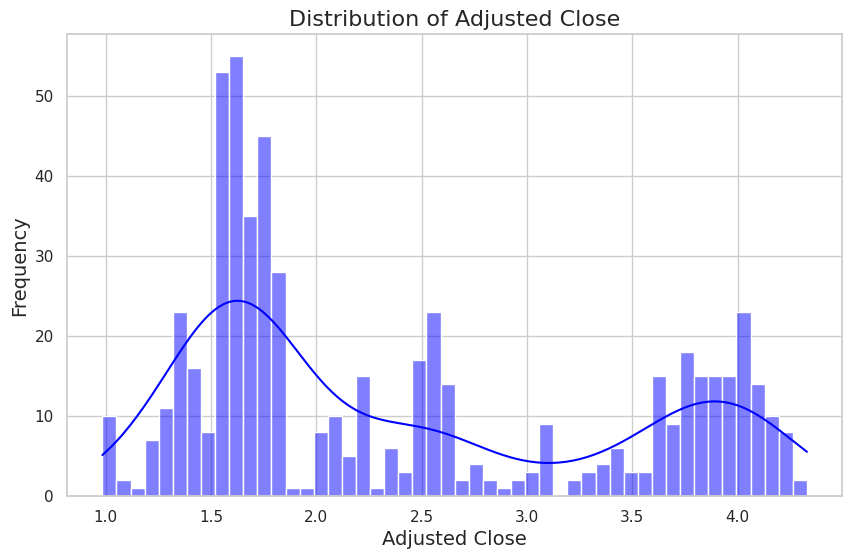

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['adjust_close'], bins=50, kde=True, color='blue')

plt.title('Distribution of Adjusted Close', fontsize=16)
plt.xlabel('Adjusted Close', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()


In [ ]:
import numpy as np

# Calculate the histogram bin counts and bin edges
counts, bin_edges = np.histogram(df['adjust_close'], bins=50)

# Find the bin with the highest frequency
most_frequent_bin_index = np.argmax(counts)
most_frequent_bin_count = counts[most_frequent_bin_index]
most_frequent_bin_range = (bin_edges[most_frequent_bin_index], bin_edges[most_frequent_bin_index + 1])

print(f"The most frequent bin is between {most_frequent_bin_range[0]:.2f} and {most_frequent_bin_range[1]:.2f}")
print(f"Frequency of the most frequent bin: {most_frequent_bin_count}")

The most frequent bin is between 1.59 and 1.65
Frequency of the most frequent bin: 55


In [ ]:
df.describe()

,Open time,Open,High,Low,Close,Volume,adjust_close,close_return
count,5.860000e+02,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,585.000000
mean,1.697803e+12,40543.335973,41490.963447,39799.679044,40619.018567,615.364335,2.407463,0.002567
std,1.462820e+10,16879.993446,17694.938807,16430.385140,16872.127296,1105.957024,1.000000,0.025562
min,1.672531e+12,16524.410000,16628.200000,16497.670000,16617.570000,5.148080,0.984913,-0.081486
25%,1.685167e+12,26963.157500,27369.635000,26605.487500,26985.132500,68.150013,1.599391,-0.009626
50%,1.697803e+12,30731.500000,31763.060000,30361.795000,30970.470000,177.616520,1.835600,0.000291
75%,1.710439e+12,59148.222500,61355.650000,57488.195000,59997.240000,469.541525,3.555997,0.013821
max,1.723075e+12,73108.440000,138070.000000,71355.770000,73020.030000,8620.941878,4.327850,0.120544


<Axes: xlabel='Close', ylabel='Count'>

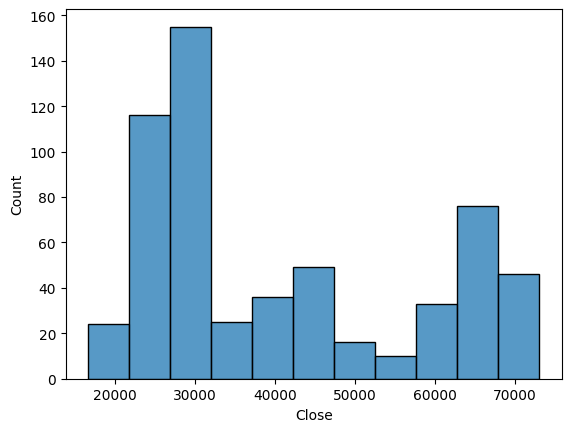

In [ ]:
sns.histplot(df['Close'])

<Axes: xlabel='adjust_close', ylabel='Count'>

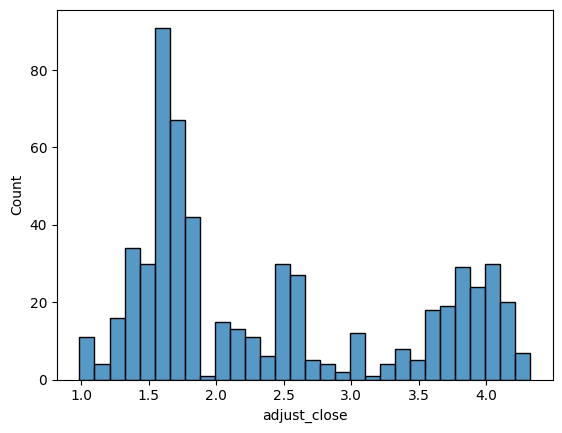

In [ ]:
sns.histplot(df['adjust_close'], bins=30)

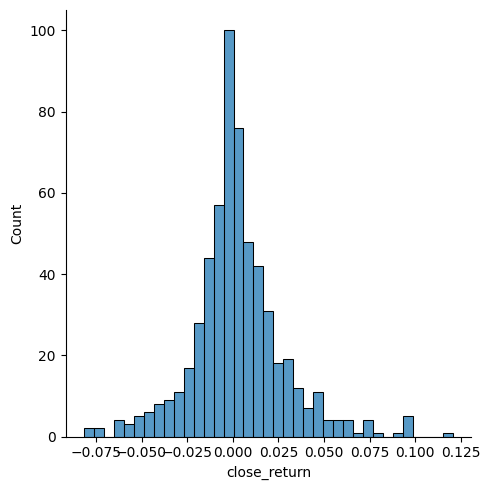

In [ ]:
sns.displot(df['close_return'])

In [ ]:
df['close_return'].mean()

0.0025669054957421452

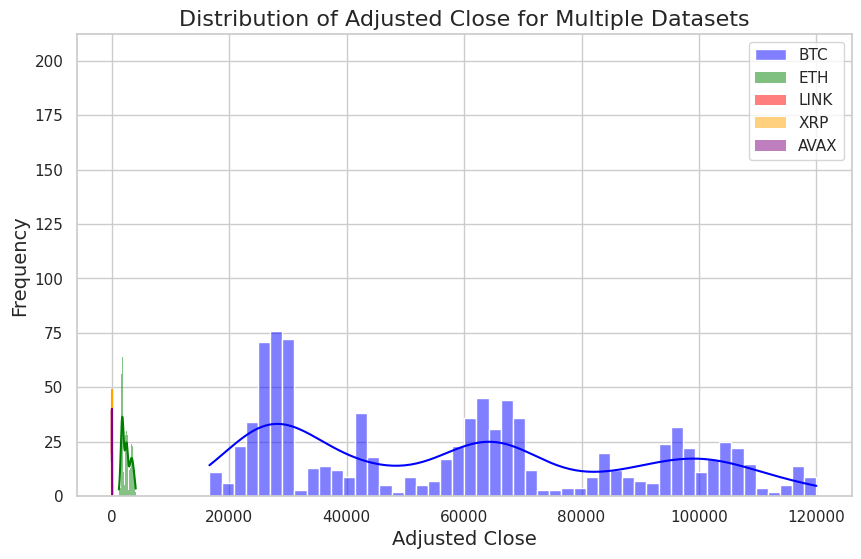

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


data = BinanceDataFetcher().get_data(symbol='BTCUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2025))
btc_df = create_dataframe(data)



data = BinanceDataFetcher().get_data(symbol='ETHUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2025))
eth_df = create_dataframe(data)



data = BinanceDataFetcher().get_data(symbol='LINKUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2025))
link_df = create_dataframe(data)


data = BinanceDataFetcher().get_data(symbol='XRPUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2025))
xrp_df = create_dataframe(data)



data = BinanceDataFetcher().get_data(symbol='AVAXUSDT', interval='1d', start=(1, 1, 2023), end=(8, 8, 2025))
avax_df = create_dataframe(data)



dataframes = [btc_df, eth_df, link_df, xrp_df, avax_df]
labels = ['BTC', 'ETH', 'LINK', 'XRP', 'AVAX']
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Different colors for each dataset

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each DataFrame and plot the 'adjust_close' distribution
for i, df in enumerate(dataframes):
    sns.histplot(df['Close'], bins=50, kde=True, color=colors[i], label=labels[i], alpha=0.5)

# Add titles and labels
plt.title('Distribution of Adjusted Close for Multiple Datasets', fontsize=16)
plt.xlabel('Adjusted Close', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a legend to differentiate the datasets
plt.legend()

# Display the plot
plt.show()


Fetching data for BTCUSDT...
Fetching data for ETHUSDT...
Fetching data for LINKUSDT...
Fetching data for SOLUSDT...
Fetching data for AVAXUSDT...


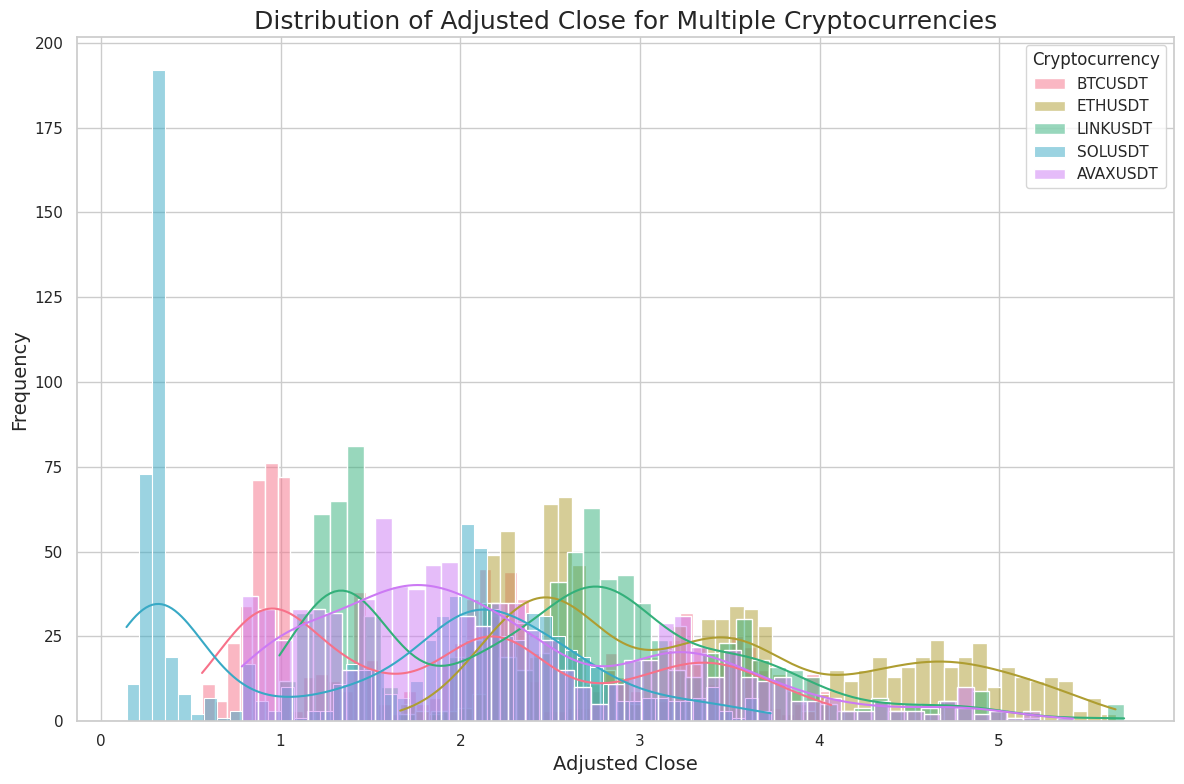

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create DataFrames, calculate 'adjust_close' and plot distributions
def fetch_and_plot_data(symbols, start, end, interval='1d'):
    dataframes = []
    labels = []

    # Loop through each symbol and fetch data
    for symbol in symbols:
        print(f"Fetching data for {symbol}...")

        # Fetch the data using BinanceDataFetcher
        data = BinanceDataFetcher().get_data(symbol=symbol, interval=interval, start=start, end=end)

        # Convert the data into a DataFrame (using an assumed `create_dataframe` function)
        df = create_dataframe(data)

        # Calculate 'adjust_close' and add to the list
        df['adjust_close'] = df['Close'] / df['Close'].std()
        dataframes.append(df)
        labels.append(symbol)  # Keep track of symbol names for labeling

    # Plot the distributions
    plot_adjust_close_distribution(dataframes, labels)

# Function to plot the distributions of 'adjust_close'
def plot_adjust_close_distribution(dataframes, labels):
    colors = sns.color_palette("husl", len(dataframes))  # Automatically generate a color palette

    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Create a figure
    plt.figure(figsize=(12, 8))

    # Loop through each DataFrame and plot the 'adjust_close' distribution
    for i, df in enumerate(dataframes):
        sns.histplot(df['adjust_close'], bins=50, kde=True, color=colors[i], label=labels[i], alpha=0.5)

    # Add titles and labels
    plt.title('Distribution of Adjusted Close for Multiple Cryptocurrencies', fontsize=18)
    plt.xlabel('Adjusted Close', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Add a legend to differentiate the datasets
    plt.legend(title='Cryptocurrency')

    # Add grid lines for better readability
    plt.grid(True)

    # Display the plot
    plt.tight_layout()  # Adjust subplots to fit in the figure area.
    plt.show()

# List of symbols to fetch and plot
symbols = ['BTCUSDT', 'ETHUSDT', 'LINKUSDT', 'SOLUSDT', 'AVAXUSDT']
start_date = (1, 1, 2023)  # Start date in (day, month, year) format
end_date = (8, 8, 2025)    # End date in (day, month, year) format

# Call the function to fetch data and plot the distributions
fetch_and_plot_data(symbols, start=start_date, end=end_date)


In [ ]:
from binance.client import Client
import pandas as pd
from datetime import datetime

class BinanceDataFetcher:
    def __init__(self):
        api_key = "rxirPy024UMkqjXGc7qWlD2euuxFMgQ2FZlWeSESSFSS8L0Q8mp5TeCvTX5SPZGX"
        api_secret = "TfZfIqudcTova5TZXwDV7O3VUaHpyNmpoiXJDfHgtsYwK4m0ttxlmaWSiVA6cuJ0"
        self.client = Client(api_key, api_secret, tld="us")

    def check_binance_connection(self):
        try:
            self.client.ping()
            return True
        except Exception as e:
            print(f"Failed to connect to Binance API: {e}")
            return False

    def _process_klines(self, klines):
        df = pd.DataFrame(klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote asset volume', 'Number of trades',
            'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
        ])
        df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
        df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
        df.drop('Open time', axis=1, inplace=True)
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            df[col] = df[col].astype(float)
        df.set_index('Date', inplace=True)
        return df

    def get_data(self, symbol, interval, start, end):
        if not isinstance(symbol, str):
            raise ValueError("Symbol must be a string")
        if not isinstance(interval, str):
            raise ValueError("Interval must be a string")
        if not (isinstance(start, tuple) and len(start) == 3):
            raise ValueError("Start date must be a tuple of (day, month, year)")
        if not (isinstance(end, tuple) and len(end) == 3):
            raise ValueError("End date must be a tuple of (day, month, year)")

        from_d, from_m, from_y = start
        to_d, to_m, to_y = end
        range_from = f"{from_y}-{from_m:02d}-{from_d:02d}T00:00:00Z"
        range_to = f"{to_y}-{to_m:02d}-{to_d:02d}T00:00:00Z"

        try:
            klines = self.client.get_historical_klines(symbol, interval, range_from, range_to)
            if not klines:
                print(f"No data found for {symbol} from {range_from} to {range_to}")
                return pd.DataFrame()
            return self._process_klines(klines)
        except Exception as e:
            print(f"Error fetching data: {e}")
            return pd.DataFrame()

In [ ]:
fetcher = BinanceDataFetcher()
data = fetcher.get_data('BTCUSDT', '1d', (1, 1, 2023), (31, 1, 2023))
print(data.head())

                Open      High       Low     Close       Volume
Date                                                           
2023-01-01  16524.41  16628.20  16497.67  16617.57   309.056051
2023-01-02  16619.93  16785.92  16549.68  16677.87   713.131373
2023-01-03  16674.84  16774.53  16604.95  16674.12   743.945758
2023-01-04  16676.49  16984.83  16653.41  16849.97  1511.331821
2023-01-05  16852.47  16878.61  16756.91  16832.48   722.090851
